# Applying a neural network for regression analysis

#### I will fit to two datasets: the 'per game' dataset and the 'three year weighted average' dataset
##### I have experimented with several different strategies, including:
- two different implementation approaches
    - standard approach: instantianting an empty error list and appending training losses to the lsit. Assigning model fit to a 'history' variable
    - approach that incorporates PCA, involving creating a custom HistoryCallback class in order to instantiate and track the loss history
- Varying the number of epochs (typically between 20 - 500)
- Varying the batch size of pass-throughs
- Scaling the data using StandardScaler vs no scaling

See main notebook for Glossary of statistical feature descriptions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# Career Per Game DF

In [40]:
# Read in nhl_career_per_game df from main Capstone Notebook
nhl_career_per_game = pd.read_csv("C:/Users/joshm/Documents/BrainStation/nhl_career_per_game.csv", index_col=0)
nhl_career_per_game

GP  G/60  A/60  G/GP  A/GP  PTS/GP  Shots/GP  PPG/GP  \
Player                                                                     
A.J. Greer          93  0.46  0.85  0.06  0.12    0.18      0.95    0.00   
Aaron Downey       119  0.40  0.70  0.03  0.06    0.09      0.39    0.00   
Aaron Ekblad       625  0.46  0.91  0.18  0.35    0.53      2.54    0.06   
Aaron Gagnon        19  0.00  0.78  0.00  0.11    0.11      0.47    0.00   
Aaron Johnson      252  0.25  0.64  0.06  0.15    0.21      0.88    0.01   
...                ...   ...   ...   ...   ...     ...       ...     ...   
Éric Gélinas       188  0.29  0.85  0.07  0.22    0.29      1.70    0.05   
Éric Perrin        241  0.49  1.10  0.13  0.30    0.43      1.58    0.02   
Ľubomír Višňovský  615  0.44  1.21  0.16  0.46    0.62      1.84    0.07   
Štefan Ružička      40  0.35  1.18  0.08  0.25    0.32      1.88    0.02   
Žigmund Pálffy      42  0.81  2.29  0.26  0.74    1.00      2.67    0.05   

                   PPA/GP  EvnG/GP  EvnA/GP  TOI/GP  
Player                                               
A.J. Greer           0.00     0.06     0.12    8.34  
Aaron Downey         0.00     0.03     0.06    5.02  
Aaron Ekblad         0.11     0.11     0.24   23.00  
Aaron Gagnon         0.00     0.00     0.11    8.05  
Aaron Johnson        0.02     0.05     0.13   14.54  
...                   ...      ...      ...     ...  
Éric Gélinas         0.11     0.03     0.11   15.35  
Éric Perrin          0.04     0.10     0.20   16.37  
Ľubomír Višňovský    0.25     0.10     0.20   22.59  
Štefan Ružička       0.08     0.05     0.18   12.72  
Žigmund Pálffy       0.21     0.21     0.52   19.33  

[2396 rows x 12 columns]

In [41]:
nhl_career_per_game['GP']

Player
A.J. Greer            93
Aaron Downey         119
Aaron Ekblad         625
Aaron Gagnon          19
Aaron Johnson        252
                    ... 
Éric Gélinas         188
Éric Perrin          241
Ľubomír Višňovský    615
Štefan Ružička        40
Žigmund Pálffy        42
Name: GP, Length: 2396, dtype: int64

In [42]:
df = nhl_career_per_game[nhl_career_per_game['GP'] >= 25]
print(df.sort_values(by='GP', ascending=False))
df = df.sort_index()

                  GP  G/60  A/60  G/GP  A/GP  PTS/GP  Shots/GP  PPG/GP  \
Player                                                                   
Ryan Suter      1362  0.18  1.00  0.08  0.41    0.49      1.66    0.03   
Alex Ovechkin   1347  1.76  1.42  0.61  0.49    1.10      4.72    0.22   
Brent Burns     1297  0.50  1.20  0.19  0.45    0.64      2.82    0.06   
Anže Kopitar    1292  0.87  1.66  0.30  0.58    0.88      2.40    0.09   
Phil Kessel     1286  1.09  1.53  0.32  0.45    0.77      2.99    0.09   
...              ...   ...   ...   ...   ...     ...       ...     ...   
Ryan Stoa         25  0.36  0.36  0.08  0.08    0.16      1.80    0.00   
Mason Geertsen    25  0.00  0.00  0.00  0.00    0.00      0.48    0.00   
Egor Yakovlev     25  0.31  0.77  0.08  0.20    0.28      0.96    0.00   
Michal Barinka    25  0.00  0.16  0.00  0.04    0.04      0.76    0.00   
Lasse Pirjetä     25  1.04  0.78  0.16  0.12    0.28      1.20    0.00   

                PPA/GP  EvnG/GP  EvnA

In [43]:
df['GP'].value_counts()

GP
27      15
47      15
41      15
39      14
43      13
        ..
851      1
1047     1
739      1
679      1
1211     1
Name: count, Length: 787, dtype: int64

## Let's jump right into fitting a neural network!
#### Train/Test Split

In [44]:
# allocating X and y variables
y = df['G/GP']
X = df.drop(columns=['GP', 'G/GP']) # every column except 'G'

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

Instantiating a feed-forward neural network. 
Also creating a custom class "HistoryCallback" in order to be able to get the history attribute from the KerasRegressor that is fit with a pipline 

Train score: 0.9779826777360412
Test score: 0.9724268879582848


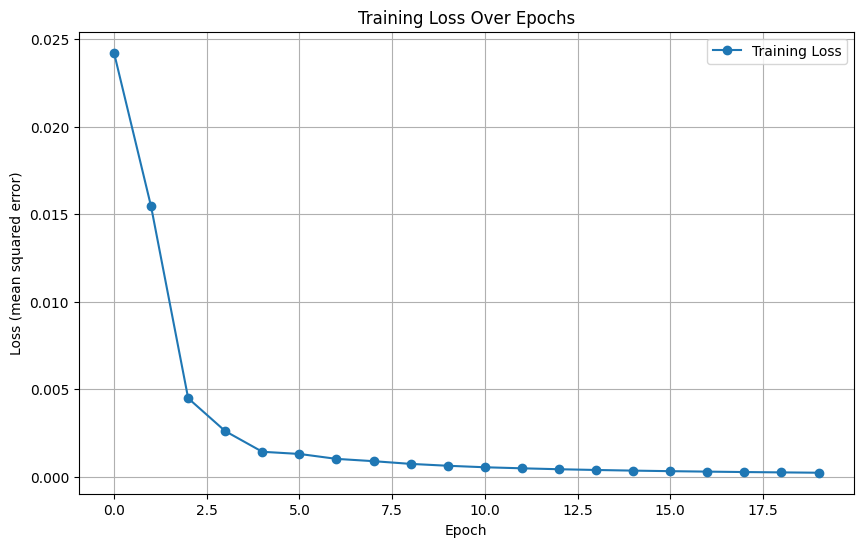

In [45]:
# Instantiating and compiling the Keras model
nhl_nn_model = Sequential()
nhl_nn_model.add(Dense(40, activation='relu', input_shape=(6,)))
nhl_nn_model.add(Dense(30, activation='relu'))
nhl_nn_model.add(Dense(20, activation='relu'))
nhl_nn_model.add(Dense(10, activation='relu'))
nhl_nn_model.add(Dense(1, activation='relu')) # Output layer for regression
nhl_nn_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=MeanSquaredError())


# Define a custom callback to capture training history
class HistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# Instantiate the custom callback
history_callback = HistoryCallback()

# Define the pipeline with custom callback
estimators = [('scaler', StandardScaler()),
              ('PCA', PCA(n_components=6)),
              ('nhl_nn_model', KerasRegressor(model=nhl_nn_model, batch_size=280, epochs=20, verbose=0, callbacks=[history_callback]))]

per_game_pipe = Pipeline(estimators)

# Fit the pipeline to your data
per_game_pipe.fit(X_train, y_train)

print(f'Train score: {per_game_pipe.score(X_train, y_train)}')
print(f'Test score: {per_game_pipe.score(X_test, y_test)}')

# Plotting the training loss from the history
plt.figure(figsize=(10, 6))
plt.plot(history_callback.losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (mean squared error)')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
X_train.shape

(1557, 10)

Alternate approach:

In [47]:
# # Instantiate a Feed Forward neural network
# nhl_nn_model = Sequential()

# # dense layers
# nhl_nn_model.add(tf.keras.layers.InputLayer(input_shape=(6,)))
# nhl_nn_model.add(Dense(40, activation='relu'))
# nhl_nn_model.add(Dense(30, activation='relu'))
# nhl_nn_model.add(Dense(20, activation='relu'))
# nhl_nn_model.add(Dense(10, activation='relu'))
# nhl_nn_model.add(Dense(1)) # Default activation is linear

# # Compiling
# nhl_nn_model.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss=tf.keras.losses.MeanSquaredError(), # MSE loss function
#              metrics=[MeanSquaredError()]) # MSE evaluation metric

In [48]:
# # Training for 20 epochs
# history = nhl_nn_model.fit(X_train, y_train, epochs=20, verbose=True)

# # Grab the prediction data
# y_pred = nhl_nn_model.predict(X_test)

# # empty list to accept loss values over epochs
# mse_list = []

# # append loss values to list
# mse_list = mse_list + history.history['mean_squared_error']

In [49]:
# # instantiating the pipeline
# from scikeras.wrappers import KerasRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score

# estimators = [('scaler', StandardScaler()),
#               ('PCA', PCA(n_components=6)),
#              ('nhl_nn_model', KerasRegressor(model=lambda: nhl_nn_model, batch_size=280, epochs=50, verbose=0))]

# per_game_pipe = Pipeline(estimators, verbose=True)

In [50]:
# # Fitting the pipline to train data

# per_game_pipe.fit(X_train, y_train, )

# print(f'Train score: {per_game_pipe.score(X_train, y_train)}')
# print(f'Test score: {per_game_pipe.score(X_test, y_test)}')

In [51]:
# from sklearn.model_selection import GridSearchCV

# params = {'scaler': [StandardScaler()], 
#           'PCA__n_components': [1, 2, 3, 4, 5, 6]}

# per_game_pipe_grid = GridSearchCV(per_game_pipe, param_grid=params)

In [52]:
# avg_val_score = np.mean(cross_val_score(per_game_pipe, X_train, y_train, cv=5))
# avg_val_score

Retrieving the number of PCA components

In [53]:
# Get the PCA step from the pipeline
pca_step = per_game_pipe.named_steps['PCA']

# Get the number of PCA components
n_components = pca_step.n_components_

n_components

6

### Calculating MSE and RMSE

In [54]:
print(y_test.shape)
y_pred = per_game_pipe.predict(X_test)
y_pred = y_pred.reshape((668,))
print(y_pred.shape)

(668,)
(668,)


In [55]:
mse = np.mean(np.square(y_test - y_pred))
mse

0.0002635381081586675

In [56]:
per_game_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('PCA', PCA(n_components=6)),
  ('nhl_nn_model',
   KerasRegressor(
   	model=<keras.src.engine.sequential.Sequential object at 0x000002477F804CD0>
   	build_fn=None
   	warm_start=False
   	random_state=None
   	optimizer=rmsprop
   	loss=None
   	metrics=None
   	batch_size=280
   	validation_batch_size=None
   	verbose=0
   	callbacks=[<__main__.HistoryCallback object at 0x000002477FA04D30>]
   	validation_split=0.0
   	shuffle=True
   	run_eagerly=False
   	epochs=20
   ))],
 'verbose': False,
 'scaler': StandardScaler(),
 'PCA': PCA(n_components=6),
 'nhl_nn_model': KerasRegressor(
 	model=<keras.src.engine.sequential.Sequential object at 0x000002477F804CD0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=280
 	validation_batch_size=None
 	verbose=0
 	callbacks=[<__main__.HistoryCallback object at 0x000002477FA04D30>]
 	validation_split=0.0
 	shuffle=True


In [57]:
# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.01623385684791718


This is the root mean squared error for actual G/GP values vs the predicted G/GP (test set)

#### Calculating r squared values for NN model

In [58]:
len(y_test)

668

In [59]:
from sklearn.metrics import r2_score

y_train_pred = per_game_pipe.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)

r2_test = r2_score(y_test, y_pred)

# Compute the number of observations (n) and number of predictors (p)
n = len(y_test)
p = n_components  # number of components

# Compute the adjusted R-squared
adjusted_r2 = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

print("r2 train", r2_train)
print("r2 test", r2_test)
print("Adjusted R-squared:", adjusted_r2)

r2 train 0.9779826777360412
r2 test 0.9724268879582848
Adjusted R-squared: 0.9721766025237155


#### Updating metrics table

In [60]:
df_scores = pd.read_csv("C:/Users/joshm/Documents/BrainStation/df_scores.csv", index_col=0)
df_scores

Train Set Score  \
Career Totals                                              0.990   
Career Totals w/ manual feature reduction                  0.862   
Per Game w/ all features                                   0.998   
Per Game w/ Pipeline & GridSearch                          0.993   
3 Year Weighted Avg w/ Pipeline & GridSearch               0.981   
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter            0.979   
KNN model w/ StandardScaler (3 yr dataset)                 1.000   

                                                 Test Set Score  \
Career Totals                                             0.990   
Career Totals w/ manual feature reduction                 0.813   
Per Game w/ all features                                  0.998   
Per Game w/ Pipeline & GridSearch                         0.993   
3 Year Weighted Avg w/ Pipeline & GridSearch              0.969   
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter           0.972   
KNN model w/ StandardScaler (3 yr dataset)                0.931   

                                                 Adjusted Rsquared    RMSE  
Career Totals                                                0.990   7.299  
Career Totals w/ manual feature reduction                    0.812  32.192  
Per Game w/ all features                                     0.998   0.004  
Per Game w/ Pipeline & GridSearch                            0.992   0.008  
3 Year Weighted Avg w/ Pipeline & GridSearch                 0.968   0.020  
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter              0.971   0.020  
KNN model w/ StandardScaler (3 yr dataset)                   0.929   0.029

In [61]:
df_scores.loc['Neural Network - Per Game Dataset', 'Train Set Score'] = round(r2_train, 3)
df_scores.loc['Neural Network - Per Game Dataset', 'Test Set Score'] = round(r2_test, 3)
df_scores.loc['Neural Network - Per Game Dataset', 'Adjusted Rsquared'] = round(adjusted_r2, 3)
df_scores.loc['Neural Network - Per Game Dataset', 'RMSE'] = round(np.sqrt(mse), 3)
df_scores

Train Set Score  \
Career Totals                                              0.990   
Career Totals w/ manual feature reduction                  0.862   
Per Game w/ all features                                   0.998   
Per Game w/ Pipeline & GridSearch                          0.993   
3 Year Weighted Avg w/ Pipeline & GridSearch               0.981   
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter            0.979   
KNN model w/ StandardScaler (3 yr dataset)                 1.000   
Neural Network - Per Game Dataset                          0.978   

                                                 Test Set Score  \
Career Totals                                             0.990   
Career Totals w/ manual feature reduction                 0.813   
Per Game w/ all features                                  0.998   
Per Game w/ Pipeline & GridSearch                         0.993   
3 Year Weighted Avg w/ Pipeline & GridSearch              0.969   
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter           0.972   
KNN model w/ StandardScaler (3 yr dataset)                0.931   
Neural Network - Per Game Dataset                         0.972   

                                                 Adjusted Rsquared    RMSE  
Career Totals                                                0.990   7.299  
Career Totals w/ manual feature reduction                    0.812  32.192  
Per Game w/ all features                                     0.998   0.004  
Per Game w/ Pipeline & GridSearch                            0.992   0.008  
3 Year Weighted Avg w/ Pipeline & GridSearch                 0.968   0.020  
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter              0.971   0.020  
KNN model w/ StandardScaler (3 yr dataset)                   0.929   0.029  
Neural Network - Per Game Dataset                            0.972   0.016

### Plotting G/GP against all independent features (Predicted and Actual) 

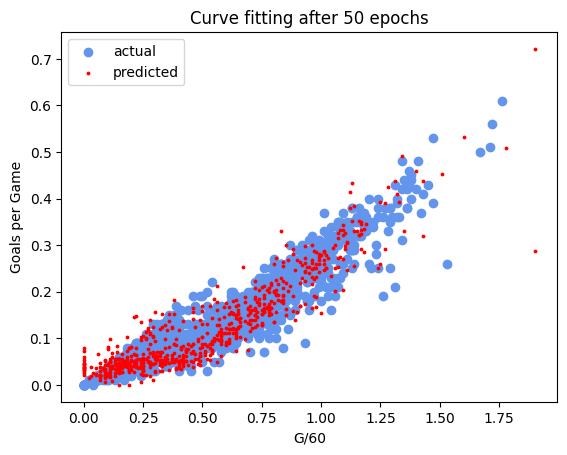

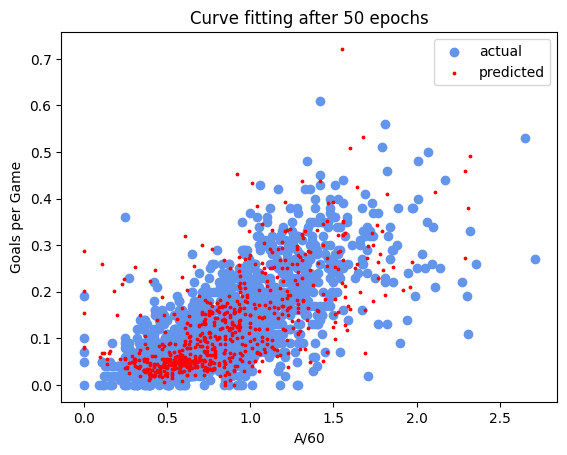

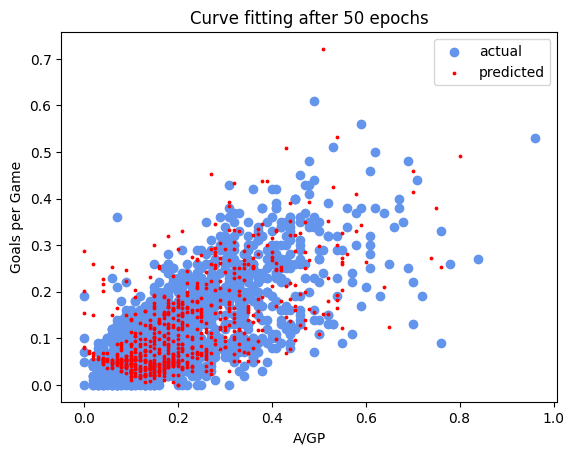

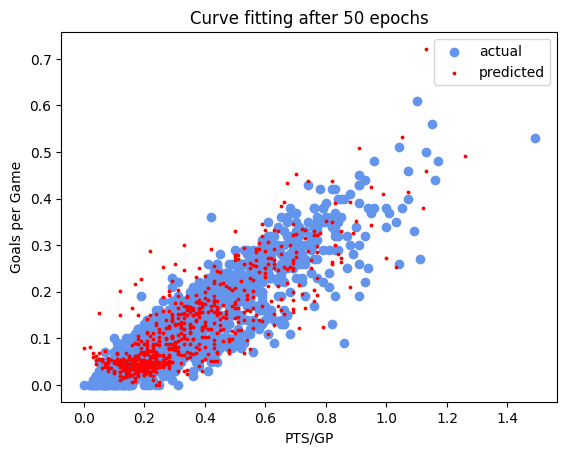

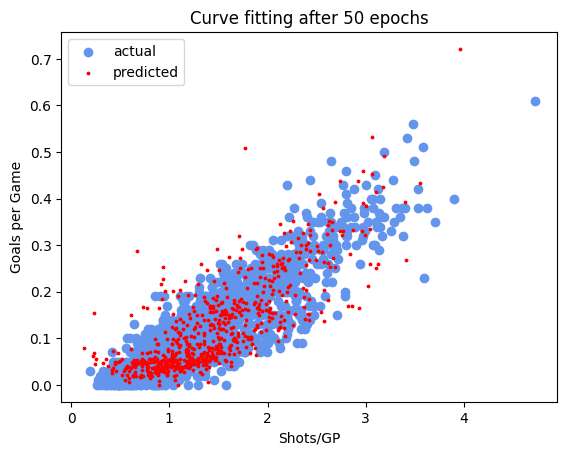

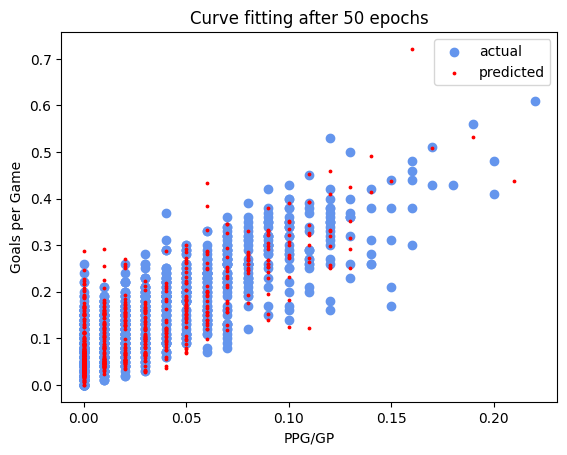

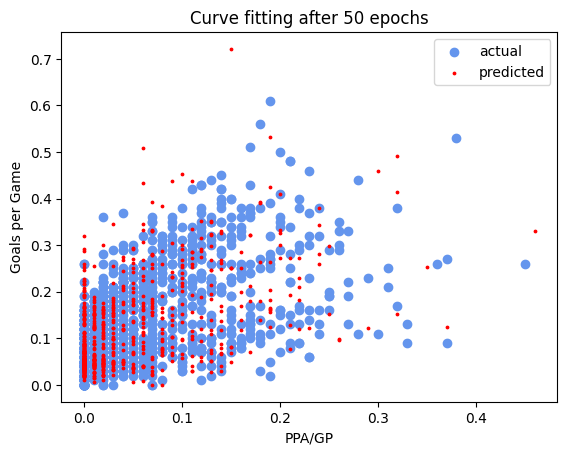

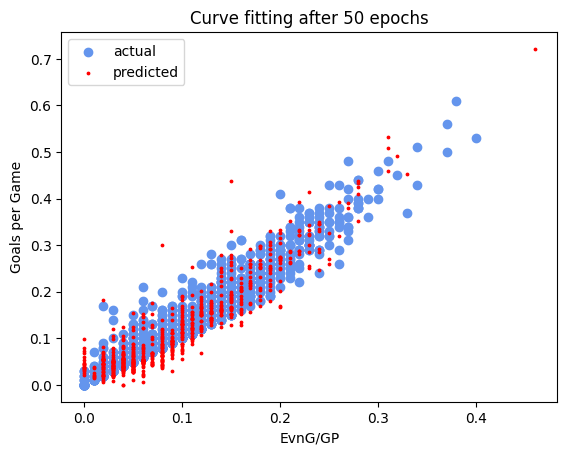

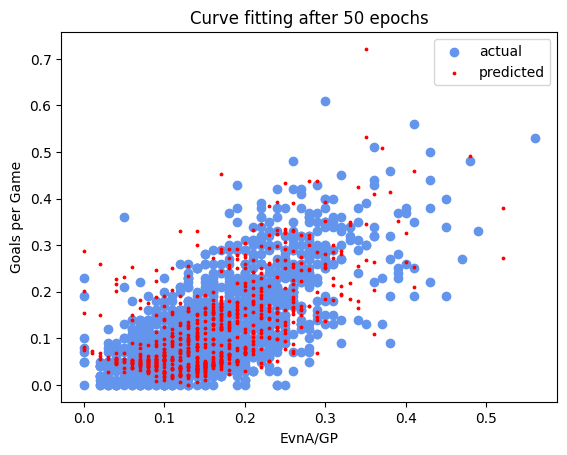

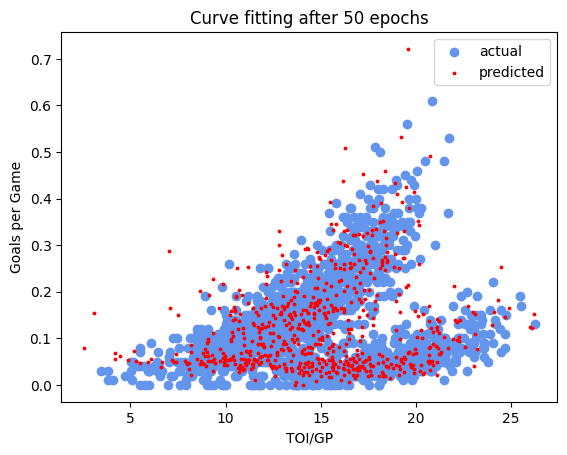

In [20]:
# Plotting target feature vs independent features - Actual vs Predicted
for col in X_train.columns:
    # Plot actual vs. predicted values for each feature
    plt.figure()
    plt.scatter(X_train[col], y_train, label='actual', c="cornflowerblue")  # Plot the actual data
    plt.scatter(X_test[col], y_pred, s=3, color='r', label='predicted')  # Plot the predicted values
    plt.legend()
    plt.xlabel(col)
    plt.ylabel('Goals per Game')
    plt.title(f'Curve fitting after 50 epochs')
    plt.show()

#### Plotting same thing as above...

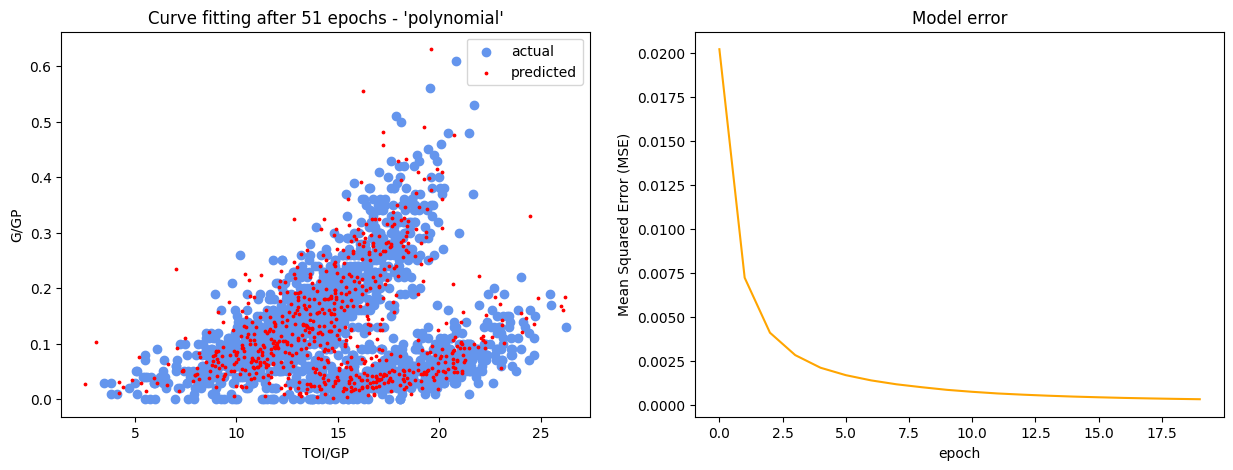

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


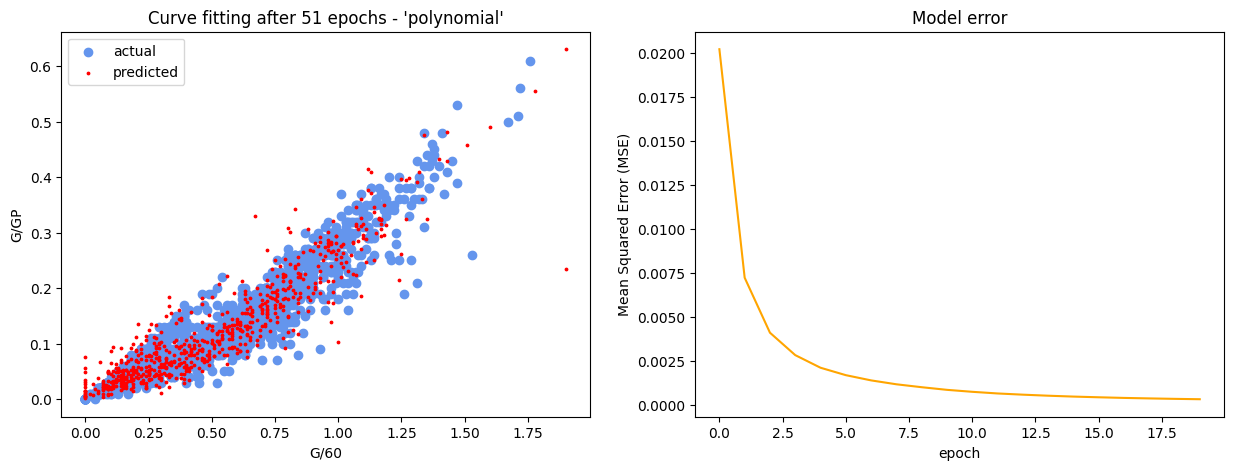

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


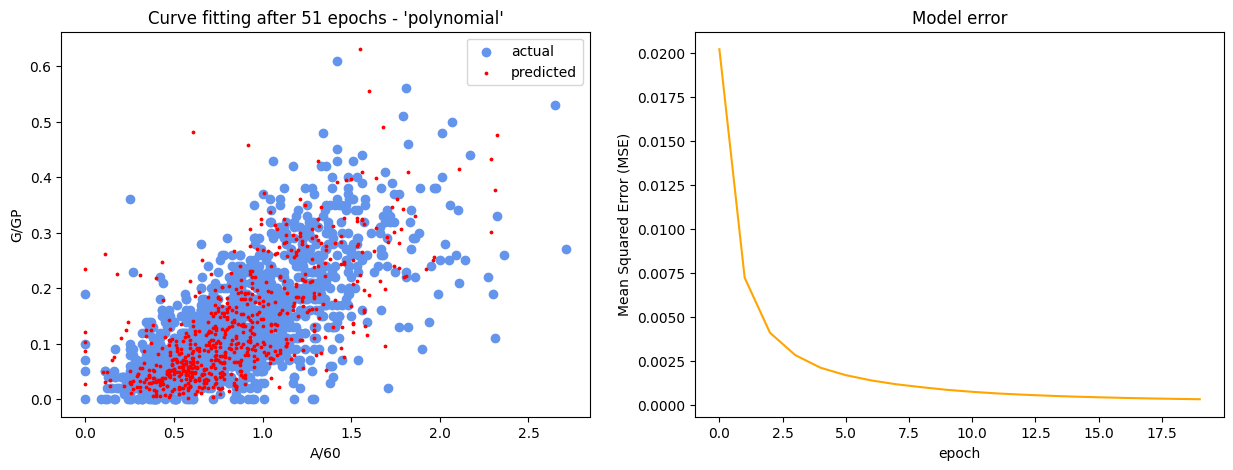

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


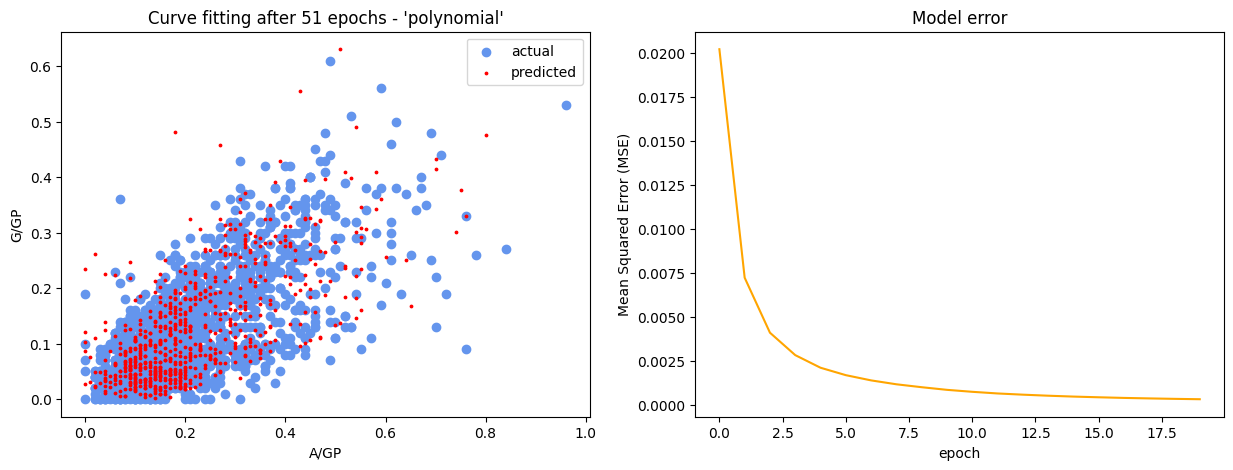

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


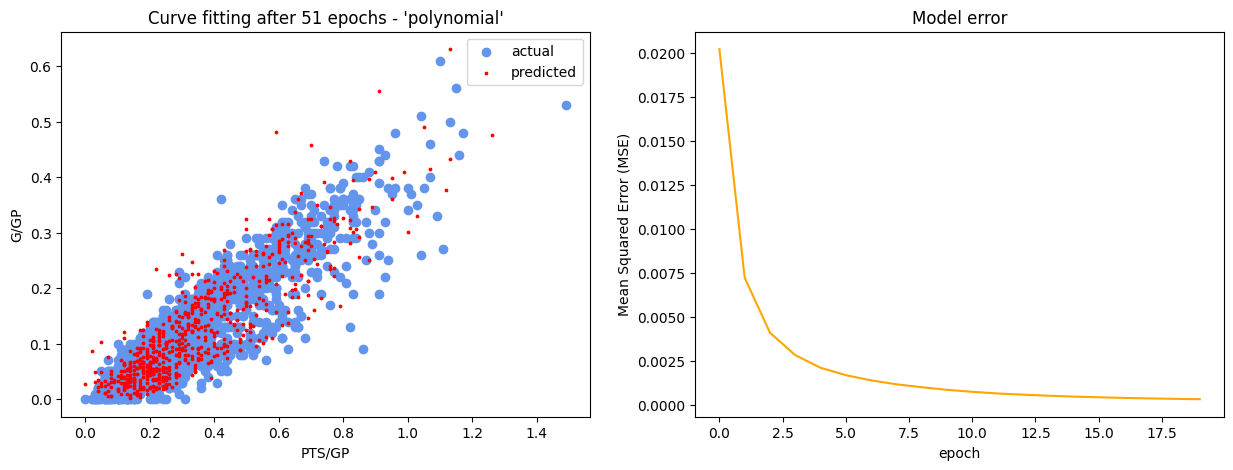

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


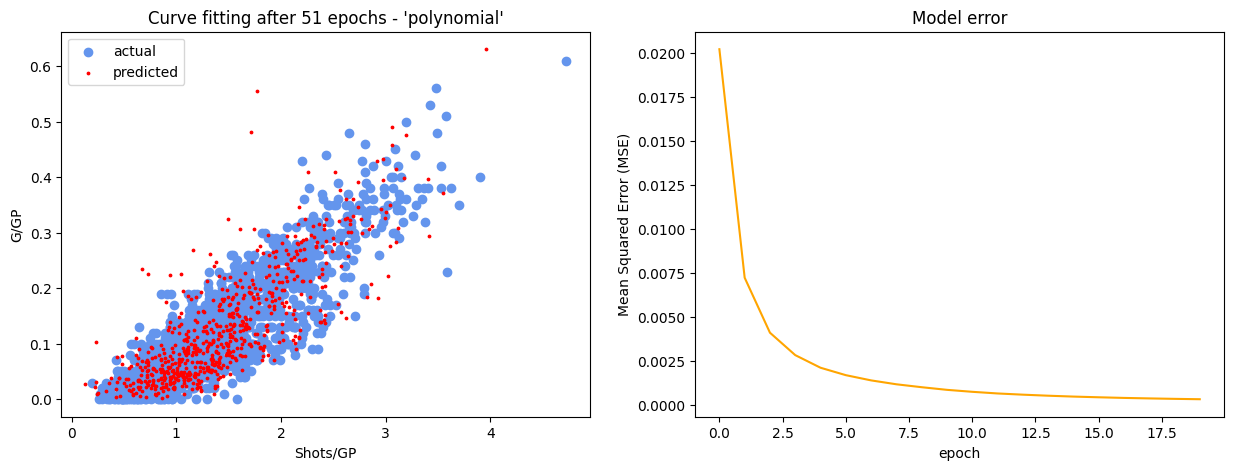

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


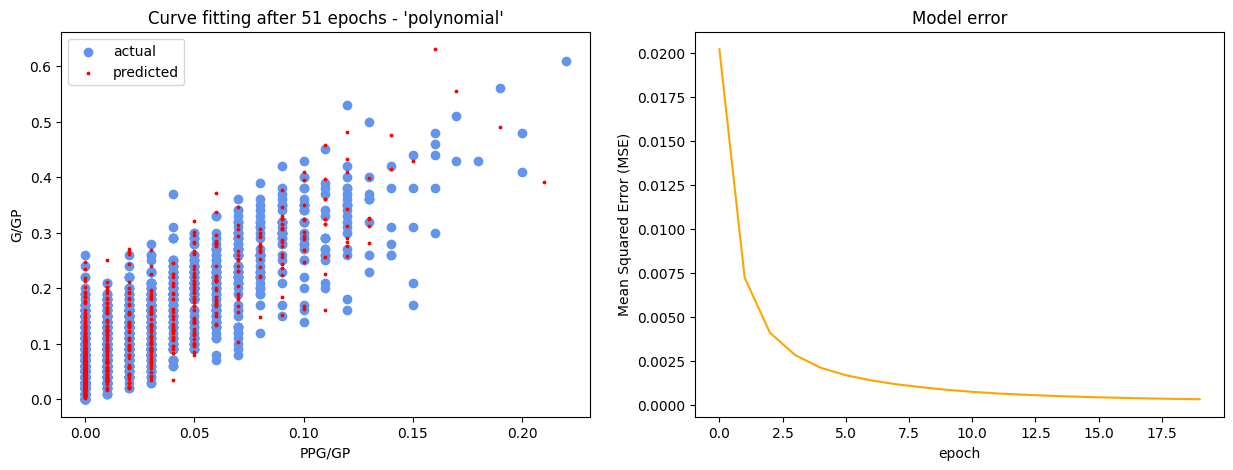

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


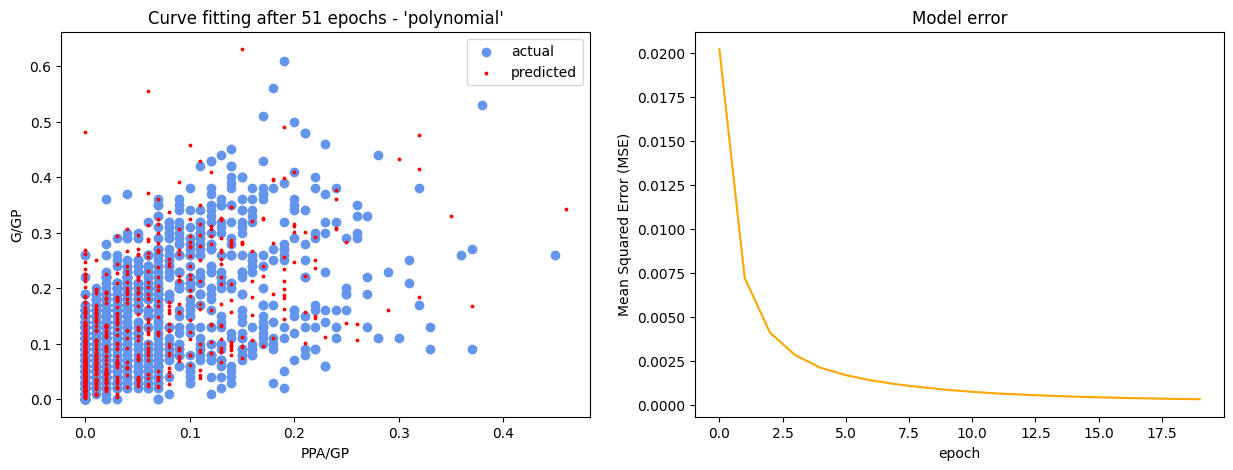

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


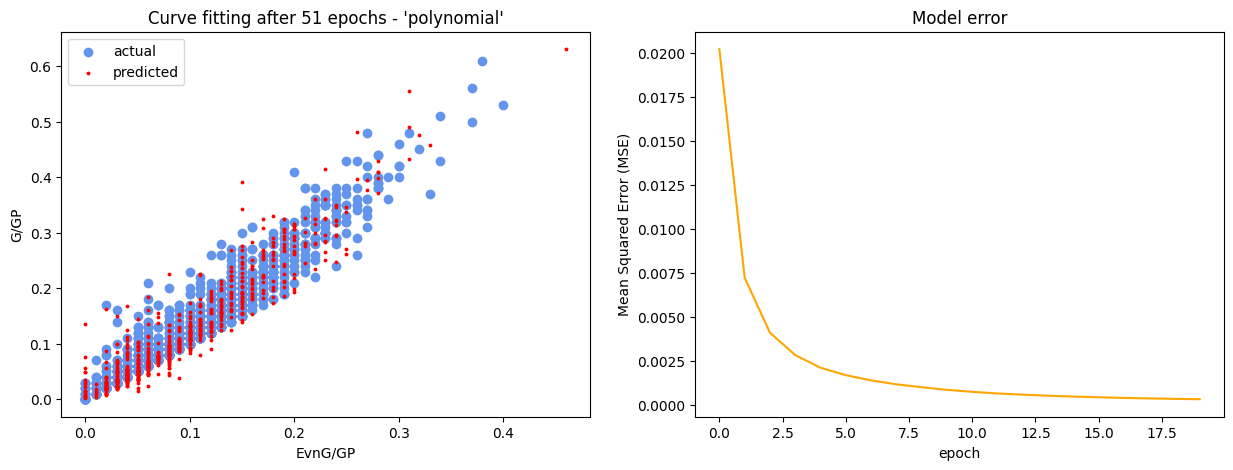

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


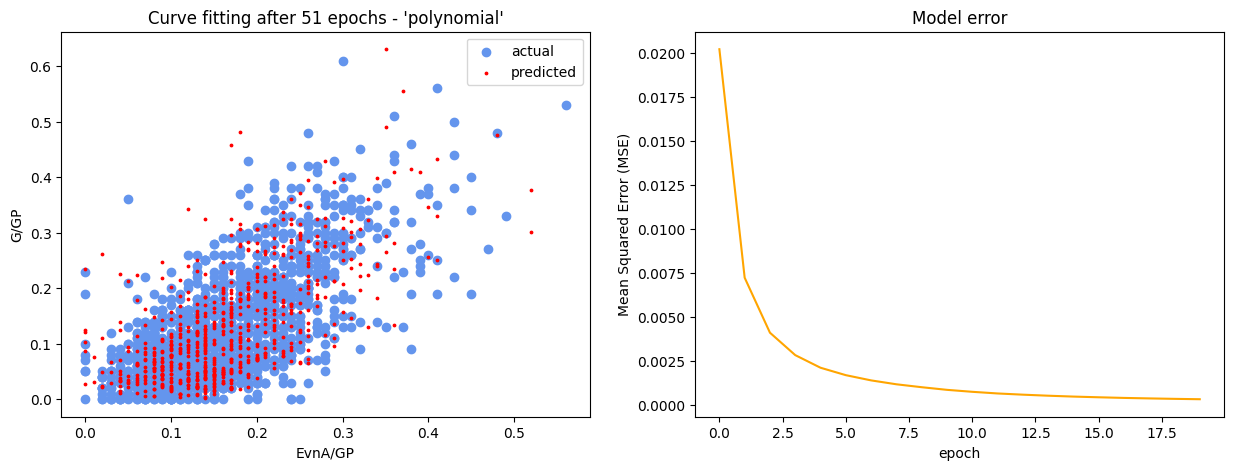

Mean Squared Error (MAE) after 51 epochs:  0.0003066244244109839


In [52]:
for col in X_test.columns:
    plt.subplots(1,2, figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.scatter(X_train[col], y_train, label='actual', c="cornflowerblue") # Plot the actual data
    plt.scatter(X_test[col], y_pred, s=3, color='r', label='predicted') # Plot the predictions
    plt.legend()
    plt.xlabel(col)
    plt.ylabel('G/GP')
    plt.title("Curve fitting after 51 epochs - 'polynomial'")
    
    # Error for each epoch
    plt.subplot(1,2,2)
    plt.plot(history_callback.losses, c='orange')
    plt.title('Model error')
    plt.xlabel('epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    
    # Show
    plt.show()
    
    # Error for the one epoch
    print('Mean Squared Error (MAE) after 51 epochs: ', history_callback.losses[-1])

### Visualizing Predicted vs Actual for test set

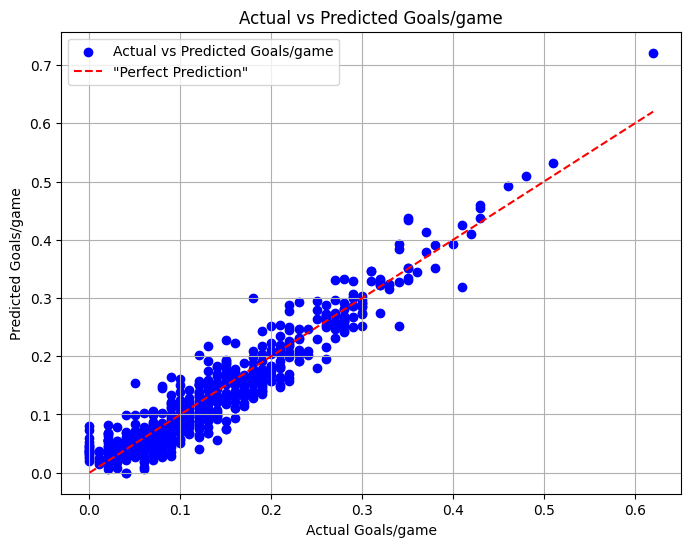

In [21]:
# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Goals/game')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='"Perfect Prediction"')
plt.xlabel('Actual Goals/game')
plt.ylabel('Predicted Goals/game')
plt.title('Actual vs Predicted Goals/game')
plt.legend()
plt.grid(True)
plt.show()

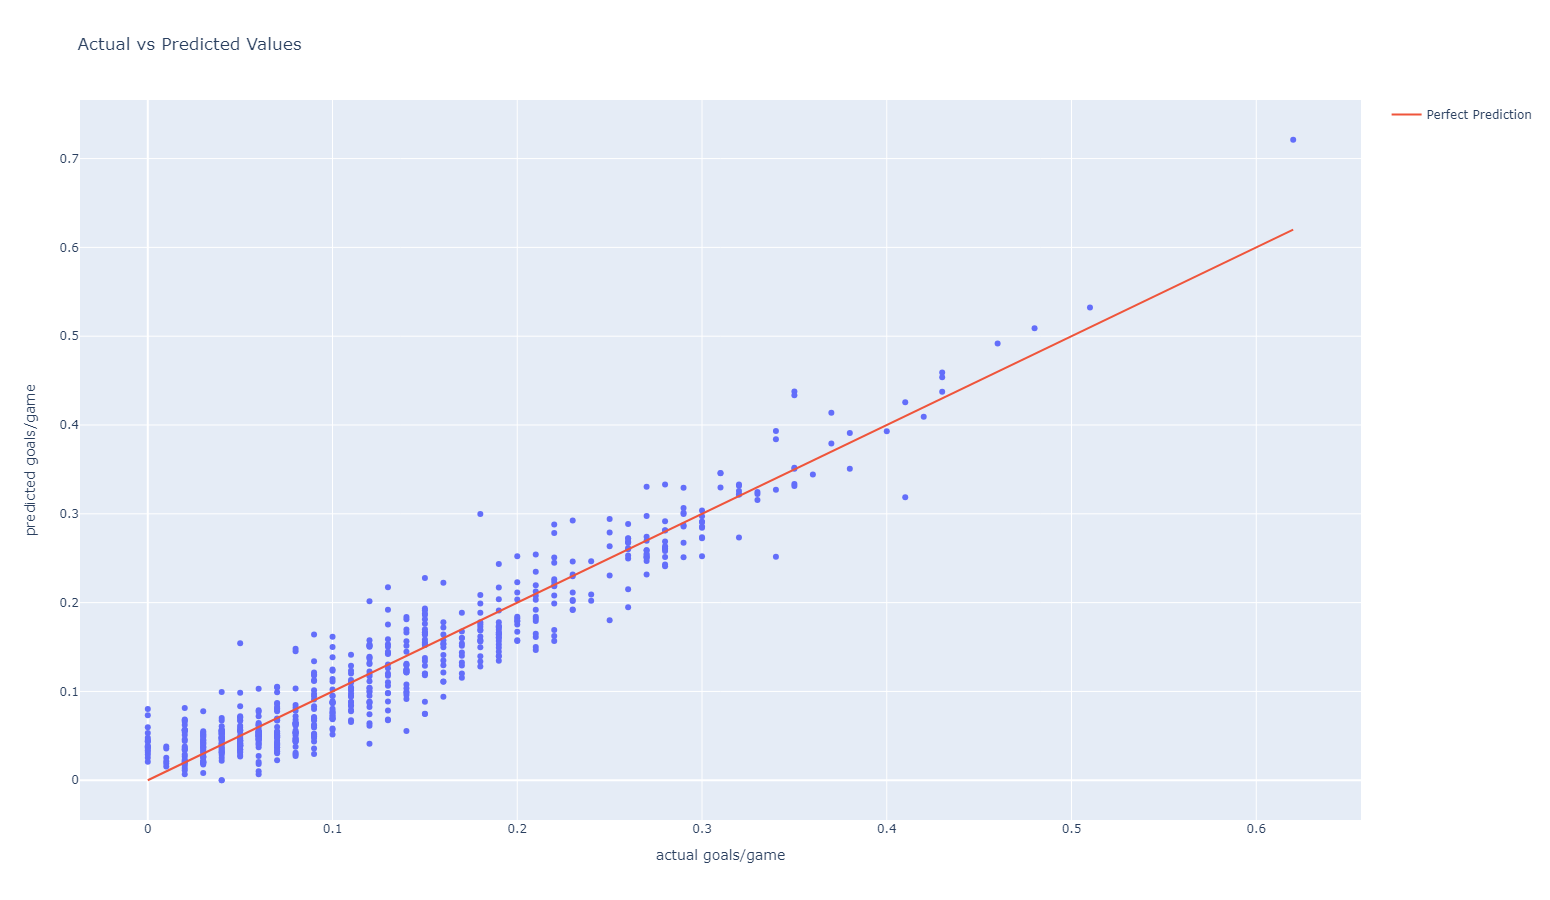

In [22]:
# Create a DataFrame with y_test and y_pred
import plotly.express as px 
import plotly.graph_objects as go
df = pd.DataFrame({'actual goals/game': y_test, 'predicted goals/game': y_pred})

# Plot y_test vs y_pred
fig = px.scatter(df, x='actual goals/game', y='predicted goals/game', title='Actual vs Predicted Values', height=900, hover_name=y_test.index)
fig.add_trace(go.Scatter(x=[df['actual goals/game'].min(), df['actual goals/game'].max()], y=[df['actual goals/game'].min(), df['actual goals/game'].max()], mode='lines', name='Perfect Prediction'))
fig.show()

### Creating a table including Difference between Predicted and Actual 

In [23]:
y_pred.shape

(668,)

In [24]:
# y_pred must have shape (741,)
df = pd.DataFrame({'actual goals/game': y_test, 'predicted goals/game': y_pred})
df

actual goals/game  predicted goals/game
Player                                                  
Nathan Bastian                0.13              0.126116
Tobias Björnfot               0.01              0.018880
Matt Hunwick                  0.05              0.038429
Emil Bemström                 0.15              0.164089
Ivan Provorov                 0.12              0.157571
...                            ...                   ...
Adam Clendening               0.05              0.045005
Shane Endicott                0.02              0.067557
Cal O'Reilly                  0.11              0.067635
Dan Hamhuis                   0.05              0.070300
David Tanabe                  0.07              0.041556

[668 rows x 2 columns]

In [25]:
df['Actual Goals'] = round((df['actual goals/game'] * 82), 2)
df['Predicted Goals'] = round((df['predicted goals/game'] * 82), 2)
df['Difference(Actual - Predicted)'] = df['Actual Goals'] - df['Predicted Goals']
df.sort_values(by='Actual Goals', ascending=False).head(20)

actual goals/game  predicted goals/game  Actual Goals  \
Player                                                                        
Auston Matthews                    0.62              0.721208         50.84   
Steven Stamkos                     0.51              0.532432         41.82   
Andrei Kuzmenko                    0.48              0.508854         39.36   
Sidney Crosby                      0.46              0.491695         37.72   
Nikita Kucherov                    0.43              0.459116         35.26   
Patrik Laine                       0.43              0.437523         35.26   
Cole Caufield                      0.43              0.453740         35.26   
Elias Pettersson                   0.42              0.409387         34.44   
Rafaël Harvey-Pinard               0.41              0.318793         33.62   
John Tavares                       0.41              0.425582         33.62   
Marián Hossa*                      0.40              0.392946         32.80   
Alexander Semin                    0.38              0.390915         31.16   
Mark Scheifele                     0.38              0.350852         31.16   
Artemi Panarin                     0.37              0.379262         30.34   
Joe Sakic*                         0.37              0.413794         30.34   
Daniel Alfredsson*                 0.36              0.344272         29.52   
Alexander Mogilny                  0.35              0.437698         28.70   
Zach Parise                        0.35              0.333607         28.70   
Jamie Benn                         0.35              0.350722         28.70   
Mika Zibanejad                     0.35              0.351862         28.70   

                      Predicted Goals  Difference(Actual - Predicted)  
Player                                                                 
Auston Matthews             59.139999                       -8.299999  
Steven Stamkos              43.660000                       -1.840000  
Andrei Kuzmenko             41.730000                       -2.370000  
Sidney Crosby               40.320000                       -2.600000  
Nikita Kucherov             37.650002                       -2.390002  
Patrik Laine                35.880001                       -0.620001  
Cole Caufield               37.209999                       -1.949999  
Elias Pettersson            33.570000                        0.870000  
Rafaël Harvey-Pinard        26.139999                        7.480001  
John Tavares                34.900002                       -1.280002  
Marián Hossa*               32.220001                        0.579999  
Alexander Semin             32.060001                       -0.900001  
Mark Scheifele              28.770000                        2.390000  
Artemi Panarin              31.100000                       -0.760000  
Joe Sakic*                  33.930000                       -3.590000  
Daniel Alfredsson*          28.230000                        1.290000  
Alexander Mogilny           35.889999                       -7.189999  
Zach Parise                 27.360001                        1.339999  
Jamie Benn                  28.760000                       -0.060000  
Mika Zibanejad              28.850000                       -0.150000

# Three year weighted average DataFrame with advanced stats added
#### Piggy-backing off of my approach for linear modelling on this data:
- I am going to remove all players that have less than 5 games played over the three year sample
- I am also removing all players that have exactly 0 Goals/Game over the sample

In [62]:
three_yr_df = pd.read_csv("C:/Users/joshm/Documents/BrainStation/three_yr_df.csv", index_col=0)
three_yr_df

Age     GP      G/GP      A/GP    PTS/GP    PPG/GP  \
Player                                                                   
A.J. Greer         27.0   71.0  0.076108  0.056735  0.168392  0.000000   
Aaron Ekblad       27.0  167.0  0.234647  0.226428  0.681598  0.103098   
Aatu Räty          20.0   15.0  0.133000  0.067000  0.200000  0.000000   
Adam Beckman       21.0    9.0  0.000000  0.000000  0.000000  0.000000   
Adam Boqvist       23.0  133.0  0.132637  0.277654  0.477863  0.024167   
...                 ...    ...       ...       ...       ...       ...   
Zachary Jones      23.0   38.0  0.030392  0.105448  0.189814  0.000000   
Zack Kassian       33.0  136.0  0.066225  0.021408  0.159696  0.011000   
Zack MacEwen       27.0  165.0  0.053147  0.058114  0.137559  0.000000   
Zdeno Chára        44.0   72.0  0.028000  0.167000  0.194000  0.000000   
Zemgus Girgensons  29.0   80.0  0.125000  0.100000  0.225000  0.000000   

                     PPA/GP   EvnG/GP   EvnA/GP      G/60      A/60  Shots/GP  \
Player                                                                          
A.J. Greer         0.000000  0.000000  0.000000  0.538088  0.643480  1.033804   
Aaron Ekblad       0.192882  0.103098  0.192882  0.579647  1.101490  2.983500   
Aatu Räty          0.000000  0.000000  0.000000  0.952000  0.476000  1.067000   
Adam Beckman       0.000000  0.000000  0.000000  0.000000  0.000000  1.333000   
Adam Boqvist       0.152098  0.024167  0.152098  0.450225  1.156010  1.330284   
...                     ...       ...       ...       ...       ...       ...   
Zachary Jones      0.018627  0.000000  0.018627  0.117647  0.628892  0.899127   
Zack Kassian       0.000000  0.011000  0.000000  0.366010  0.473510  0.687971   
Zack MacEwen       0.000000  0.000000  0.000000  0.299608  0.471343  1.162716   
Zdeno Chára        0.000000  0.000000  0.000000  0.089000  0.534000  1.125000   
Zemgus Girgensons  0.012000  0.000000  0.012000  0.578000  0.462000  1.425000   

                      TOI/GP  
Player                        
A.J. Greer          8.696931  
Aaron Ekblad       24.202235  
Aatu Räty           8.400000  
Adam Beckman       10.667000  
Adam Boqvist       17.811314  
...                      ...  
Zachary Jones      15.360402  
Zack Kassian       10.511833  
Zack MacEwen       10.410333  
Zdeno Chára        18.736000  
Zemgus Girgensons  12.975000  

[1065 rows x 13 columns]

## Instantiating pipeline and defining keras neural network model
Also creating a custom `HistoryCallback` class that mimics the function of the `.history` attribute of  

In [63]:
# allocating X and y variables
y = three_yr_df['G/GP']
X = three_yr_df.drop(columns=['GP', 'G/GP'])

# all rate stats --> in theory data is scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

Train score: 0.9810770153919584
Test score: 0.9425623810017192


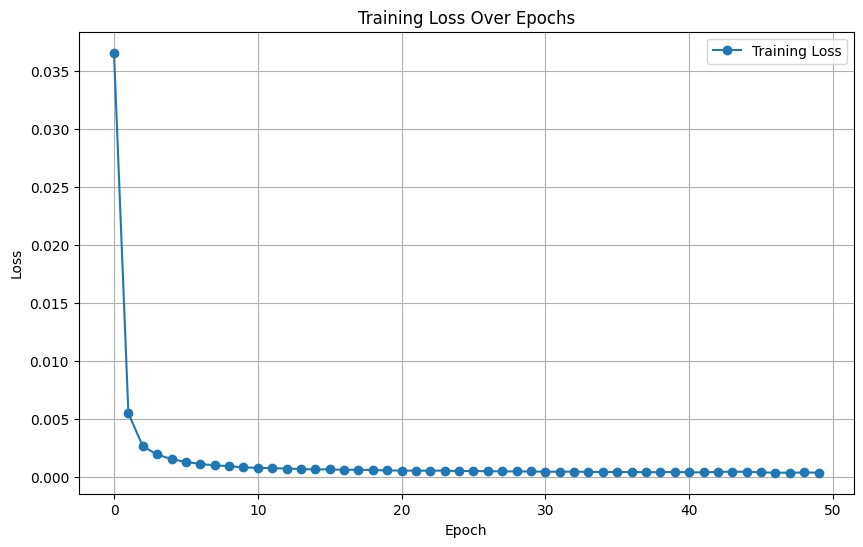

In [64]:
# Instantiating and compiling the Keras model
three_yr_nn_model = Sequential()
three_yr_nn_model.add(Dense(40, activation='relu', input_shape=(6,)))
three_yr_nn_model.add(Dense(30, activation='relu'))
three_yr_nn_model.add(Dense(20, activation='relu'))
three_yr_nn_model.add(Dense(10, activation='relu'))
three_yr_nn_model.add(Dense(1)) # Output layer for regression
three_yr_nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=MeanSquaredError())

# Define a custom callback to capture training history
class HistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# Instantiate the custom callback
history_callback = HistoryCallback()

# Define the pipeline with custom callback
estimators = [('scaler', StandardScaler()),
              ('PCA', PCA(n_components=6)),
              ('three_yr_nn_model', KerasRegressor(model=three_yr_nn_model, epochs=50, verbose=0, callbacks=[history_callback]))]

three_yr_pipe = Pipeline(estimators)

# Fit the pipeline to your data
three_yr_pipe.fit(X_train, y_train)

print(f'Train score: {three_yr_pipe.score(X_train, y_train)}')
print(f'Test score: {three_yr_pipe.score(X_test, y_test)}')

# Plot the training loss from the history
plt.figure(figsize=(10, 6))
plt.plot(history_callback.losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
avg_val_score = np.mean(cross_val_score(three_yr_pipe, X_train, y_train, cv=5))
avg_val_score

INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmp36hpotfl\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmp36hpotfl\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpln5mcb7m\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpln5mcb7m\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpg499eobv\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpg499eobv\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpgfk2lxzw\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpgfk2lxzw\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmppat42qx6\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmppat42qx6\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpwhgqdjlx\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpwhgqdjlx\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmp88zpt1f0\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmp88zpt1f0\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpohnbuy0a\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpohnbuy0a\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpubfr17u9\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmpubfr17u9\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmph1djkfcw\assets


INFO:tensorflow:Assets written to: C:\Users\joshm\AppData\Local\Temp\tmph1djkfcw\assets


0.9570945317642474

#### This approach does not incorporate a pipeline with PCA...

In [93]:
# from tensorflow.keras import layers
# # Instantiate a Feed Forward neural network
# three_yr_nn_model = Sequential()

# three_yr_nn_model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
# three_yr_nn_model.add(Dense(40, activation='relu'))
# three_yr_nn_model.add(layers.BatchNormalization()) 
# three_yr_nn_model.add(Dense(30, activation='relu'))
# three_yr_nn_model.add(layers.BatchNormalization()) 
# three_yr_nn_model.add(Dense(20, activation='relu'))
# three_yr_nn_model.add(layers.BatchNormalization()) 
# three_yr_nn_model.add(Dense(10, activation='relu'))
# three_yr_nn_model.add(layers.BatchNormalization()) 

# # Single node output
# three_yr_nn_model.add(Dense(1, activation='relu'))

# # Compile the model
# three_yr_nn_model.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss=tf.keras.losses.MeanSquaredError(), # MSE loss function
#              metrics=[MeanSquaredError()]) # MSE evaluation metric


# # empty list to accept loss values over epochs
# mse_list = []

# # Training for 50 epochs
# history = three_yr_nn_model.fit(X_train, y_train, batch_size=200, epochs=50, verbose=True, validation_data=(X_test, y_test)) # also grabbing validation data

# # Grab the prediction data
# y_pred = three_yr_nn_model.predict(X_test)

# # append loss values to list
# mse_list = mse_list + history.history['mean_squared_error']

In [32]:
X_test.shape

(320, 11)

In [33]:
y_test.shape

(320,)

### Calculating MSE and RMSE

In [66]:
print(y_test.shape)
y_pred = three_yr_pipe.predict(X_test)
y_pred = y_pred.reshape((320,))
print(y_pred.shape)

(320,)
(320,)


In [67]:
mse = np.mean(np.square(y_test - y_pred))
mse

0.0007290541014635413

In [68]:
# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.027001001860366983


#### Calculating r squared values for 3 yr NN

In [69]:
from sklearn.metrics import r2_score
y_train_pred = three_yr_pipe.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)

r2_test = r2_score(y_test, y_pred)

# Compute the number of observations (n) and number of predictors (p)
n = len(y_test)
p = X_train.shape[1]  # Assuming X is your feature matrix with shape (n_samples, n_features)

# Compute the adjusted R-squared
adjusted_r2 = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

print("r2 train", r2_train)
print("r2 test", r2_test)
print("Adjusted R-squared:", adjusted_r2)

r2 train 0.9810770153919584
r2 test 0.9425623810017192
Adjusted R-squared: 0.9405110374660663


#### Updating metrics table

In [70]:
df_scores.loc['Neural Network - 3 Yr Weighted Dataset', 'Train Set Score'] = round(r2_train, 3)
df_scores.loc['Neural Network - 3 Yr Weighted Dataset', 'Test Set Score'] = round(r2_test, 3)
df_scores.loc['Neural Network - 3 Yr Weighted Dataset', 'Adjusted Rsquared'] = round(adjusted_r2, 3)
df_scores.loc['Neural Network - 3 Yr Weighted Dataset', 'RMSE'] = round(np.sqrt(mse), 3)
df_scores

Train Set Score  \
Career Totals                                              0.990   
Career Totals w/ manual feature reduction                  0.862   
Per Game w/ all features                                   0.998   
Per Game w/ Pipeline & GridSearch                          0.993   
3 Year Weighted Avg w/ Pipeline & GridSearch               0.981   
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter            0.979   
KNN model w/ StandardScaler (3 yr dataset)                 1.000   
Neural Network - Per Game Dataset                          0.978   
Neural Network - 3 Yr Weighted Dataset                     0.981   

                                                 Test Set Score  \
Career Totals                                             0.990   
Career Totals w/ manual feature reduction                 0.813   
Per Game w/ all features                                  0.998   
Per Game w/ Pipeline & GridSearch                         0.993   
3 Year Weighted Avg w/ Pipeline & GridSearch              0.969   
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter           0.972   
KNN model w/ StandardScaler (3 yr dataset)                0.931   
Neural Network - Per Game Dataset                         0.972   
Neural Network - 3 Yr Weighted Dataset                    0.943   

                                                 Adjusted Rsquared    RMSE  
Career Totals                                                0.990   7.299  
Career Totals w/ manual feature reduction                    0.812  32.192  
Per Game w/ all features                                     0.998   0.004  
Per Game w/ Pipeline & GridSearch                            0.992   0.008  
3 Year Weighted Avg w/ Pipeline & GridSearch                 0.968   0.020  
3 Year Weighted Avg w/ Pipeline & 0 G/GP filter              0.971   0.020  
KNN model w/ StandardScaler (3 yr dataset)                   0.929   0.029  
Neural Network - Per Game Dataset                            0.972   0.016  
Neural Network - 3 Yr Weighted Dataset                       0.941   0.027

### Plotting G/GP against all independent features (Predicted and Actual) 

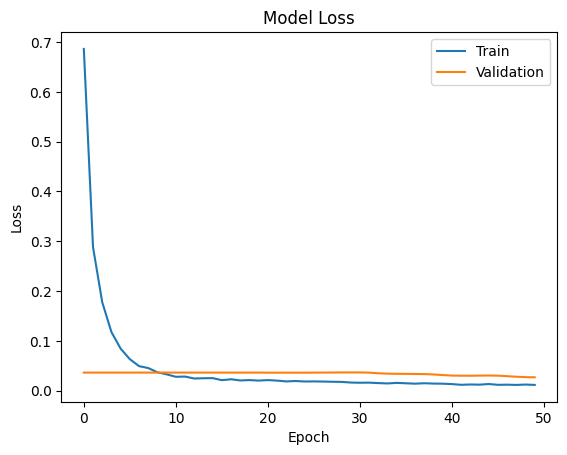

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [20]:
X_train

A/GP    PTS/GP    PPG/GP    PPA/GP   EvnG/GP  \
Player                                                                   
Oliver Ekman-Larsson  0.267493  0.415480  0.020304  0.113686  0.020304   
Trent Frederic        0.091781  0.311382  0.000000  0.000000  0.000000   
Brady Tkachuk         0.351441  0.890206  0.119147  0.157098  0.119147   
Jonathan Huberdeau    0.390284  1.012990  0.062010  0.265696  0.062010   
Mathew Barzal         0.409529  0.844667  0.041706  0.234735  0.041706   
...                        ...       ...       ...       ...       ...   
Marc Staal            0.095451  0.195843  0.000000  0.000000  0.000000   
Max Comtois           0.134657  0.357000  0.003353  0.037735  0.003353   
Klim Kostin           0.179330  0.346324  0.000000  0.000000  0.000000   
Luke Glendening       0.052464  0.157029  0.000000  0.000000  0.000000   
Christian Dvorak      0.185598  0.508461  0.032461  0.056069  0.032461   

                       EvnA/GP      G/60      A/60  Shots/GP     TOI/GP  
Player                                                                   
Oliver Ekman-Larsson  0.113686  0.143755  1.047304  1.841343  21.022157  
Trent Frederic        0.000000  0.847588  0.738500  1.479147  11.712039  
Brady Tkachuk         0.157098  1.251735  1.615765  3.985971  18.611853  
Jonathan Huberdeau    0.265696  0.926755  2.397431  2.092814  17.980559  
Mathew Barzal         0.234735  0.784627  1.955422  2.342147  18.494853  
...                        ...       ...       ...       ...        ...  
Marc Staal            0.000000  0.139147  0.516725  0.851314  17.985471  
Max Comtois           0.037735  0.668157  0.820186  1.448294  14.225902  
Klim Kostin           0.000000  0.779853  1.181275  0.732108  10.455637  
Luke Glendening       0.000000  0.339510  0.347775  1.144353  13.231412  
Christian Dvorak      0.056069  0.676127  1.081529  1.492706  17.315039  

[647 rows x 10 columns]

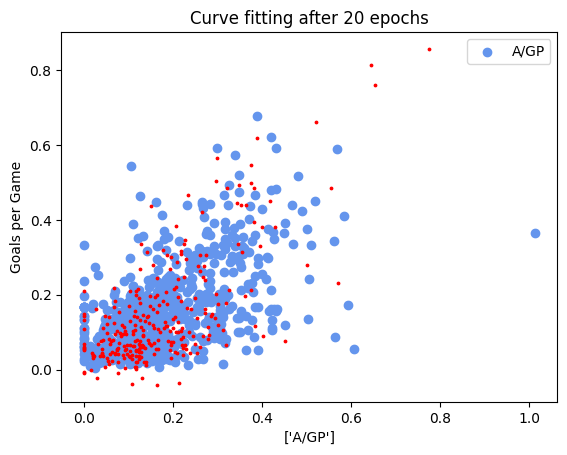

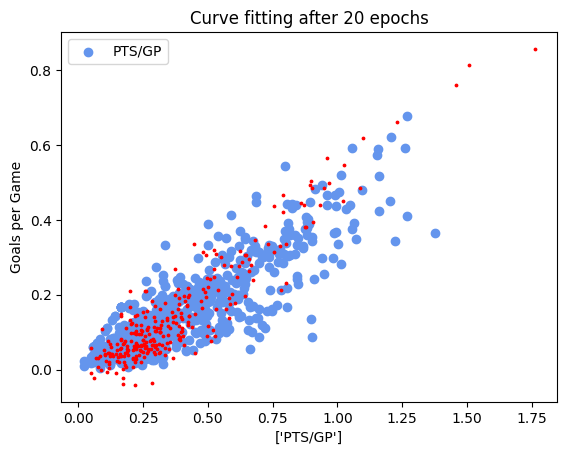

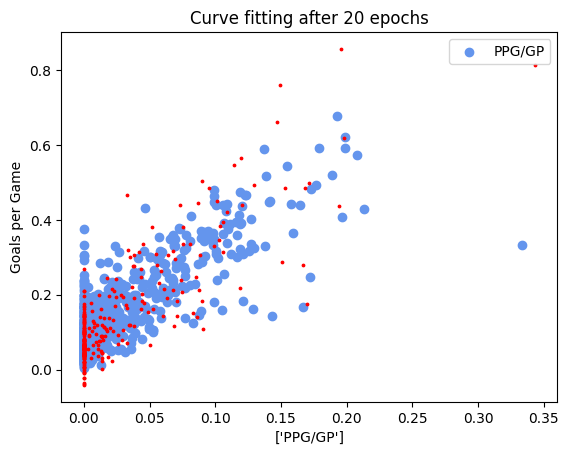

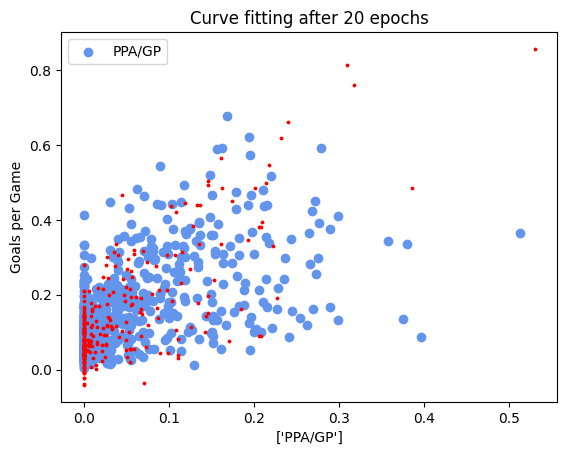

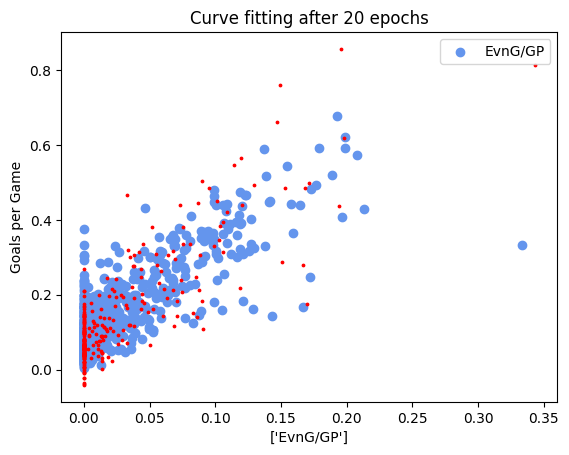

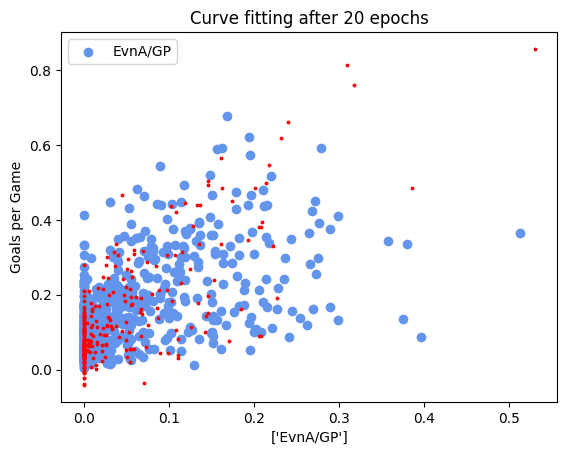

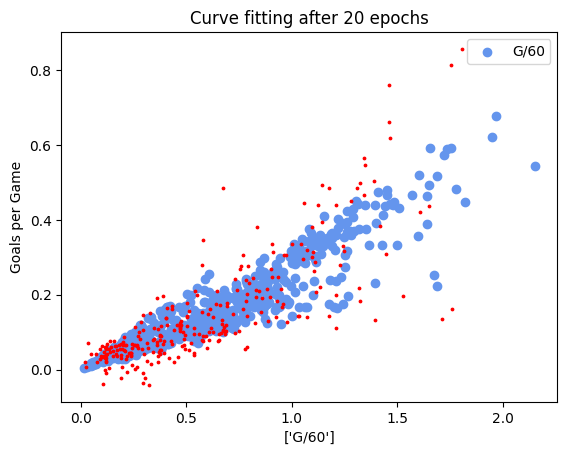

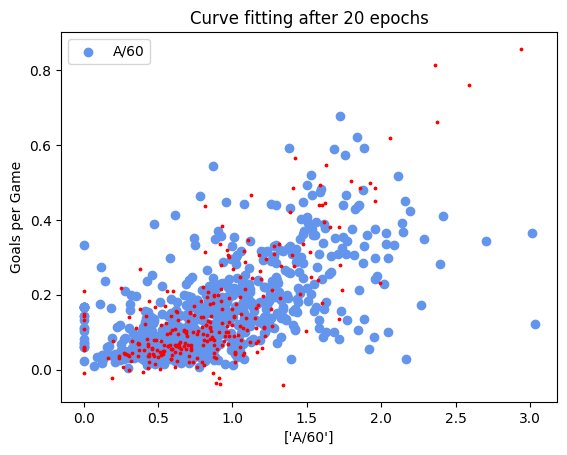

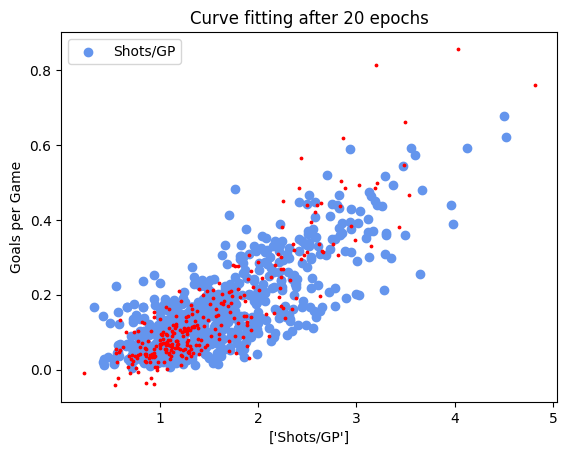

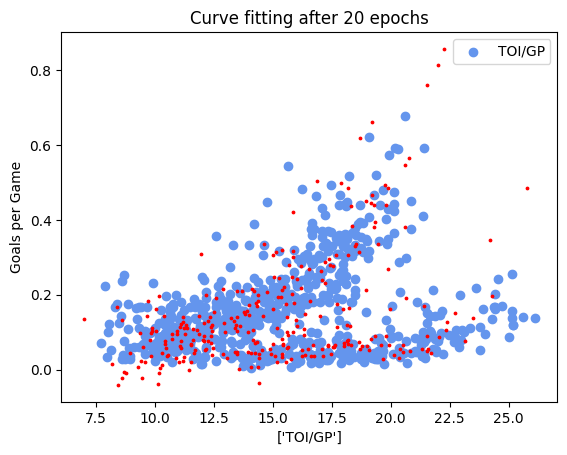

Mean Squared Error (MSE) for 50 epochs:  0.002981718862429261


In [24]:
# Plotting target feature vs independent features - Actual vs Predicted
for col in X_train.columns:
    # Plot actual vs. predicted values for each feature
    plt.figure()
    plt.scatter(X_train[col], y_train, label='actual', c="cornflowerblue")  # Plot the actual data
    plt.scatter(X_test[col], y_pred, s=3, color='r', label='predicted')  # Plot the predicted values
    plt.legend([col])
    plt.xlabel([col])
    plt.ylabel('Goals per Game')
    plt.title(f'Curve fitting after 20 epochs')
    plt.show()

# Error for the one epoch
print('Mean Squared Error (MSE) for 50 epochs: ', mse_list[-1])

Calculating MSE and RMSE

### Visualizing Predicted vs Actual for test set

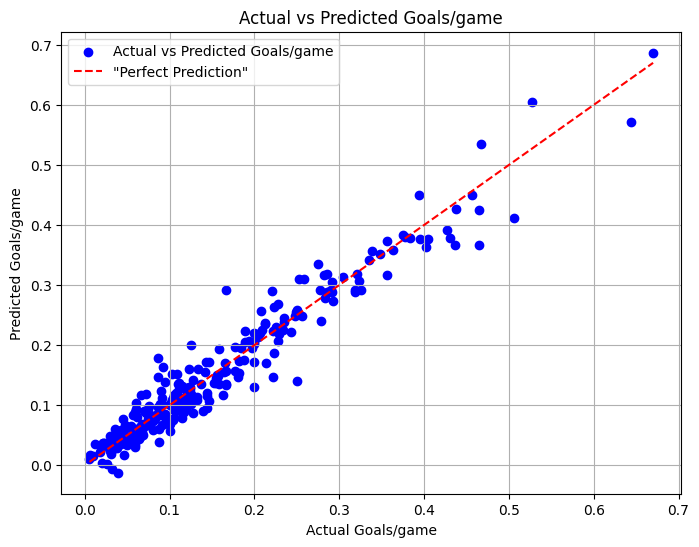

In [115]:
# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Goals/game')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='"Perfect Prediction"')
plt.xlabel('Actual Goals/game')
plt.ylabel('Predicted Goals/game')
plt.title('Actual vs Predicted Goals/game')
plt.legend()
plt.grid(True)
plt.show()

Plotly express interactive plot

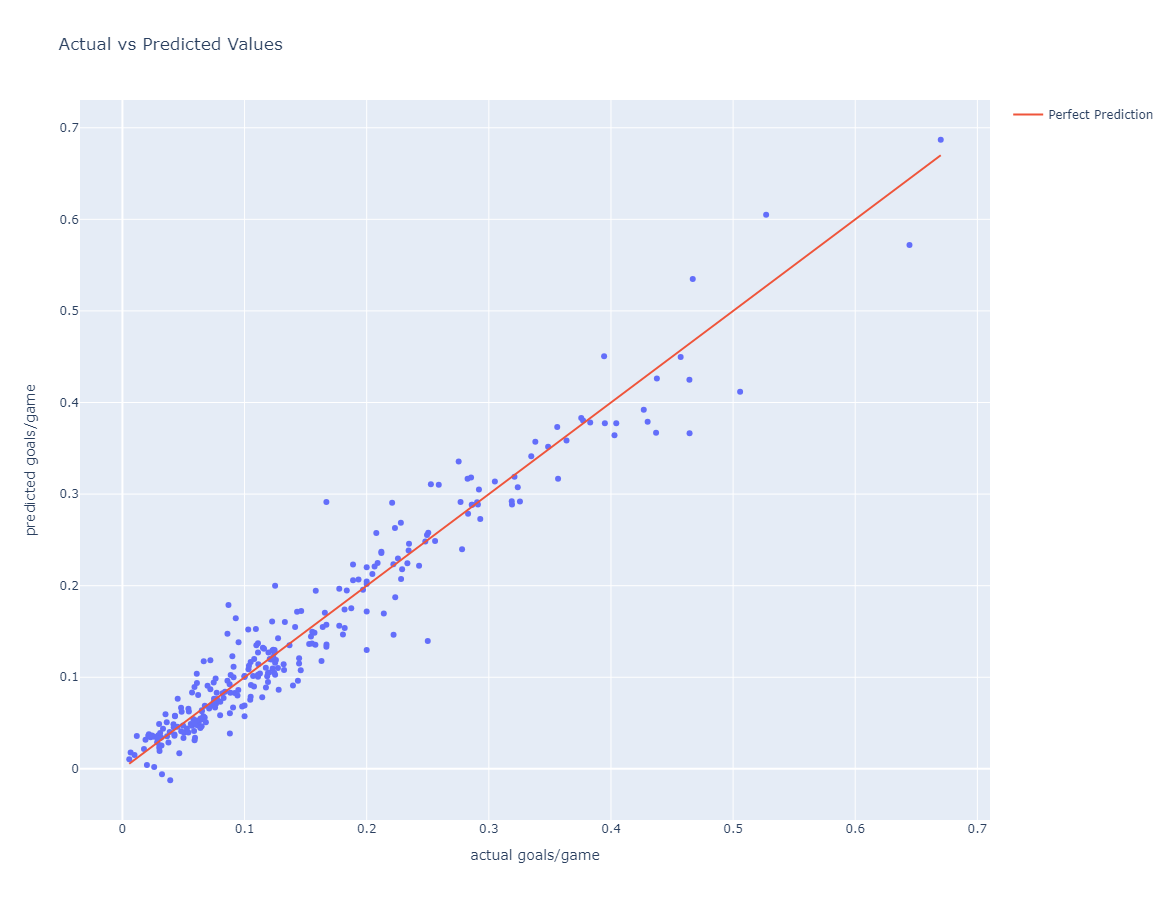

In [116]:
df = pd.DataFrame({'actual goals/game': y_test, 'predicted goals/game': y_pred})

# Plot y_test vs y_pred
fig = px.scatter(df, x='actual goals/game', y='predicted goals/game', title='Actual vs Predicted Values', height=900, hover_name=y_test.index)
fig.add_trace(go.Scatter(x=[df['actual goals/game'].min(), df['actual goals/game'].max()], y=[df['actual goals/game'].min(), df['actual goals/game'].max()], mode='lines', name='Perfect Prediction'))
fig.show()

### Creating a table including Difference between Predicted and Actual 

In [117]:
# y_pred must have shape (741,)
df2 = pd.DataFrame({'actual goals/game': y_test, 'predicted goals/game': y_pred})
df2

actual goals/game  predicted goals/game
Player                                                    
Gustav Lindström            0.018902              0.031753
Taylor Raddysh              0.256000              0.248909
Matt Irwin                  0.035265              0.059647
Dmitry Kulikov              0.050529              0.039481
Shea Weber                  0.125000              0.199943
...                              ...                   ...
Isaak Phillips              0.062000              0.080723
Jake Lucchini               0.091000              0.111542
Fredrik Händemark           0.125000              0.102655
Adam Ružička                0.124578              0.129783
Hendrix Lapierre            0.167000              0.157441

[278 rows x 2 columns]

In [118]:
df2['Actual Goals'] = round((df2['actual goals/game'] * 82), 2)
df2['Predicted Goals'] = round((df2['predicted goals/game'] * 82), 2)
df2['Difference(Actual - Predicted)'] = df2['Actual Goals'] - df2['Predicted Goals']
df2.sort_values(by='Predicted Goals', ascending=False).head(20)

actual goals/game  predicted goals/game  Actual Goals  \
Player                                                                    
Connor McDavid             0.670010              0.686897         54.94   
Nathan MacKinnon           0.527049              0.604949         43.22   
Leon Draisaitl             0.644412              0.572053         52.84   
Matthew Tkachuk            0.466961              0.534968         38.29   
John Tavares               0.394382              0.450541         32.34   
Steven Stamkos             0.457059              0.449816         37.48   
Alex DeBrincat             0.437598              0.426141         35.88   
Kyle Connor                0.464225              0.424757         38.07   
Chris Kreider              0.505745              0.411799         41.47   
Jared McCann               0.426853              0.392137         35.00   
Dylan Larkin               0.375647              0.383172         30.80   
Tim Stützle                0.377137              0.380355         30.93   
Evander Kane               0.430029              0.379120         35.26   
Matt Boldy                 0.383000              0.378088         31.41   
Pavel Buchnevich           0.404343              0.377450         33.16   
Jordan Kyrou               0.395000              0.377477         32.39   
Kirill Marchenko           0.356000              0.373351         29.19   
Adrian Kempe               0.436931              0.367083         35.83   
Mark Scheifele             0.464353              0.366321         38.08   
Clayton Keller             0.402882              0.364131         33.04   

                  Predicted Goals  Difference(Actual - Predicted)  
Player                                                             
Connor McDavid          56.330002                       -1.390002  
Nathan MacKinnon        49.610001                       -6.390001  
Leon Draisaitl          46.910000                        5.930000  
Matthew Tkachuk         43.869999                       -5.579999  
John Tavares            36.939999                       -4.599999  
Steven Stamkos          36.880001                        0.599999  
Alex DeBrincat          34.939999                        0.940001  
Kyle Connor             34.830002                        3.239998  
Chris Kreider           33.770000                        7.700000  
Jared McCann            32.160000                        2.840000  
Dylan Larkin            31.420000                       -0.620000  
Tim Stützle             31.190001                       -0.260001  
Evander Kane            31.090000                        4.170000  
Matt Boldy              31.000000                        0.410000  
Pavel Buchnevich        30.950001                        2.209999  
Jordan Kyrou            30.950001                        1.439999  
Kirill Marchenko        30.610001                       -1.420001  
Adrian Kempe            30.100000                        5.730000  
Mark Scheifele          30.040001                        8.039999  
Clayton Keller          29.860001                        3.179999

What is going on here?<br>
- Small sample size
- Too many independent features?
- 

In [119]:
X.corr()

Age      A/GP    PTS/GP    PPG/GP    PPA/GP   EvnG/GP  \
Age       1.000000  0.031458  0.068485  0.066851  0.050792  0.066851   
A/GP      0.031458  1.000000  0.874403  0.562446  0.829273  0.562446   
PTS/GP    0.068485  0.874403  1.000000  0.768755  0.840870  0.768755   
PPG/GP    0.066851  0.562446  0.768755  1.000000  0.619829  1.000000   
PPA/GP    0.050792  0.829273  0.840870  0.619829  1.000000  0.619829   
EvnG/GP   0.066851  0.562446  0.768755  1.000000  0.619829  1.000000   
EvnA/GP   0.050792  0.829273  0.840870  0.619829  1.000000  0.619829   
G/60     -0.085916  0.375820  0.684547  0.670330  0.385780  0.670330   
A/60      0.088259  0.900397  0.885086  0.568880  0.770676  0.568880   
Shots/GP  0.076925  0.667342  0.847808  0.717769  0.693991  0.717769   
TOI/GP    0.168112  0.603390  0.565616  0.360215  0.586623  0.360215   

           EvnA/GP      G/60      A/60  Shots/GP    TOI/GP  
Age       0.050792 -0.085916  0.088259  0.076925  0.168112  
A/GP      0.829273  0.375820  0.900397  0.667342  0.603390  
PTS/GP    0.840870  0.684547  0.885086  0.847808  0.565616  
PPG/GP    0.619829  0.670330  0.568880  0.717769  0.360215  
PPA/GP    1.000000  0.385780  0.770676  0.693991  0.586623  
EvnG/GP   0.619829  0.670330  0.568880  0.717769  0.360215  
EvnA/GP   1.000000  0.385780  0.770676  0.693991  0.586623  
G/60      0.385780  1.000000  0.472615  0.629954 -0.021599  
A/60      0.770676  0.472615  1.000000  0.654467  0.427082  
Shots/GP  0.693991  0.629954  0.654467  1.000000  0.542398  
TOI/GP    0.586623 -0.021599  0.427082  0.542398  1.000000

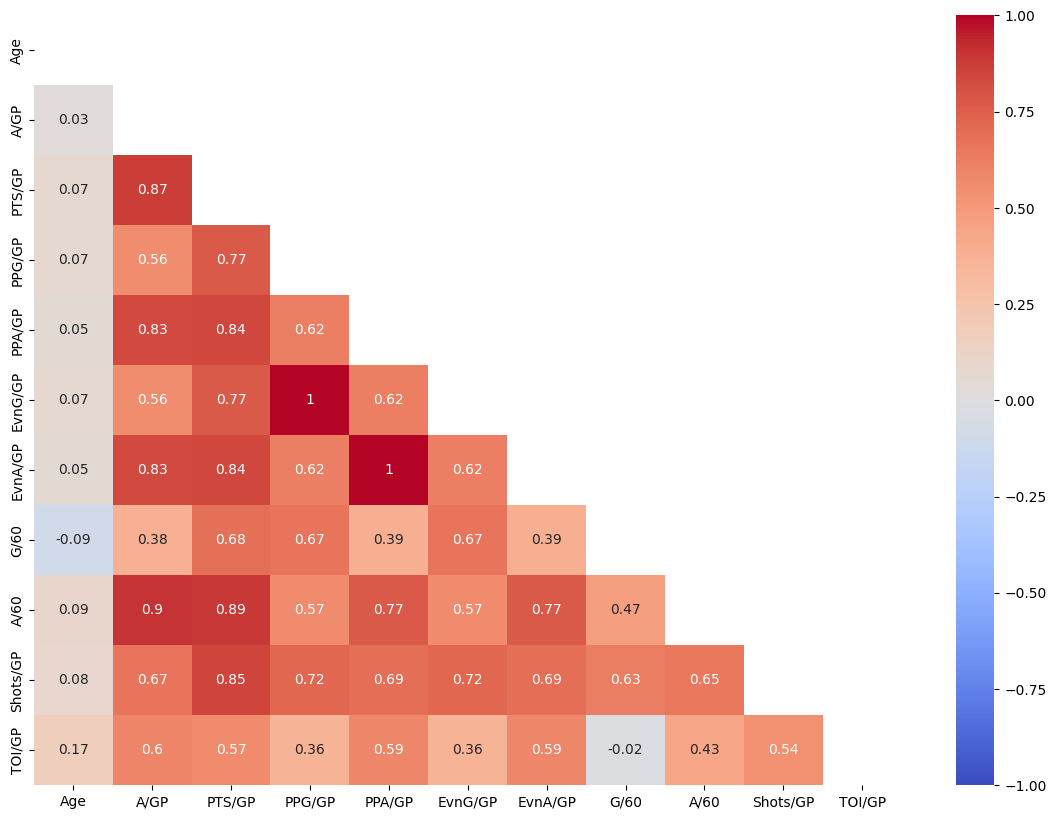

In [120]:
# Calculate all the correlations between each independent variable
import seaborn as sns
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(14,10))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

Observations and Conclusions for Neural Network Modeling
- After a lot of trial and error, these two model iterations are performing admirably.
- I ultimately decided to go with the implementation approach that allowed me to fit the data with PCA feature reduction.
- The loss dropped very quickly. 20 epochs were sufficient to bring the loss down to minimal levels
- I suspect that the NN is overfitting to the train data.
    - The test score drops relative to the train score for the three year average model